In [1]:
from lmfit import minimize, Parameters, fit_report
import lmfit
import pandas as pd
import tellurium as te
import numpy as np

import matplotlib.pyplot as plt

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
from emll.aesara_utils import LeastSquaresSolve

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import the data 
df = pd.read_csv('data/twostep_1.05.csv')

In [3]:
r = te.loada('models/twostep.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

In [4]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

v_star = df[fluxes].loc[0]

## Setting up linlog variables
Dimensions for the following:

*e and v must be same length*

- `ex` is (#rxn, #intmet) aka (n,m)
- `ey` is (#rxn, #extmet) aka (n,p)

- `en` is 
- `xn` is (#intmet, #rxn) aka (m,n)
- `yn` is (#extmet, #rxn) aka (p,n)
- `vn` is 

In [5]:
ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

In [6]:
en = df[enzymes].loc[1:len(internal)+1]/df[enzymes].loc[0]
xn = df[internal].loc[1:len(internal)+1]/df[internal].loc[0]
yn = df[external].iloc[-(len(external)):]/df[external].loc[0]
vn = df[fluxes].loc[1:len(internal)+1]/df[fluxes].loc[0]

## Best case scenarios for linlog. 
Here, I calculate the linlog equation with groundtruth values calculated through
tellurium, subtract them from the ground truth flux values, and calculate the 
chi squared value.

I compare whether to scalar or matrix multiply the first factor of the equation 
(`outer`). 

In [7]:
# scalar multiplication
gt_fluxes = df[fluxes].loc[1:2].values
inner = np.ones((2,2)) + (ex@np.log(xn).T).values + (ey@np.log(yn).T).values
outer = (en.values*v_star.values) # (.05 * np.diag(v_star)) + (v_star[0]*np.ones((2,2)))
print(outer)

linlog_fluxes = (outer * inner).T
res = linlog_fluxes - gt_fluxes
(res*res).sum()

[[2.88126623 2.74406307]
 [2.74406307 2.88126623]]


0.01705007851326588

In [8]:
# matrix multiplication
gt_fluxes = df[fluxes].loc[1:2].values
inner = np.ones((2,2)) + (ex@np.log(xn).T).values + (ey@np.log(yn).T).values
outer = (en*np.diag(v_star.values)).values # np.diag(1.05 * v_star)
print(outer)

linlog_fluxes = (outer @ inner).T
res = linlog_fluxes - gt_fluxes
(res*res).sum()


[[2.88126623 0.        ]
 [0.         2.88126623]]


0.05646390858283317

The chi squared value for the matrix multiplication is higher, so perhaps this 
suggests that the scalar multiplication method is more accurate. 

## Using lmfit to predict elasticity values w/o ey values

In [9]:
def cb(params, iter, resid, *args, **kws):
    print(iter, (resid**2).sum().sum())

def residual(params, xn, v_star, df, *args, **kws):
    
    some_list = []
    Ex_params = [i for i in params if 'Ex' in i]
    for i in Ex_params:
        some_list.append(params[i])
    ex = np.asarray(some_list).reshape((2,1))

    # a = (.05 * np.diag(v_star)) + (v_star[0]*np.ones((2,2)))
    a = (en.values*v_star.values)
    bb = np.ones((2,2))
    cc = ex@(np.log(xn)).T

    model = a*(bb + cc)

    return (df[fluxes].loc[1:len(internal)+1].values-model.T).values

params = Parameters()

for i in range(2*(1)):
    params.add('Ex'+str(i), value=0, min=-10, max=10)

out = minimize(residual, params, args=(xn, v_star, df))#, iter_cb=cb)

print(out.chisqr)
out.params

3.7188884432560864e-07


name,value,standard error,relative error,initial value,min,max,vary
Ex0,-0.59479989,0.00299161,(0.50%),0,-10.0000000,10.0000000,True
Ex1,0.75160370,0.00299138,(0.40%),0,-10.0000000,10.0000000,True


Perfect results!

Here is the ratio of the elasticity values:

In [10]:
first_ratio = out.params['Ex0'] / out.params['Ex1']
first_ratio

-0.791374344962222

Let's compute some control coefficients.

In [11]:
def estimate_CCs(Ex):
    vn[vn == 0] = 1e-6
    
    a = np.diag(en.values / vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1, axis=0)

    Ex_ss = a @ Ex
    As = N @ np.diag(v_star) @ Ex_ss
    bs = N @ np.diag(v_star)
    bs = bs[np.newaxis, :].repeat(1, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(N.T))
    identity = identity[np.newaxis,:].repeat(1, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return FCC

In [12]:
# flag Herbert
estimate_CCs(ex)

 [[ 1.44029, -0.559709]]

In [13]:
r.getScaledFluxControlCoefficientMatrix()

            J1,       J2
J1 [[ 0.558306, 0.441694],
J2  [ 0.558306, 0.441694]]

## Using lmfit to predict elasticity values with the inclusion of ey values

Unfortunately, lmfit cannot fit a case where the number of inputs (Ex values + 
Ey values = 6 unknowns) is greater than the number of outputs (4 flux values). 

Therefore, I will pass in only the nonzero Ey values as a parameter

In [14]:
def residual(params, xn, yn, v_star, df, *args, **kws):
    
    ex = np.array([params['Ex0'], params['Ex1']]).reshape((2,1))

    ey = np.zeros((2,2))
    ey[0,0] = params['Ey0']
    ey[1,1] = params['Ey1']

    a = en.values*v_star.values
    
    bb = np.ones((2,2))
    cc = ex@(np.log(xn)).T
    dd = ey@(np.log(yn)).T
    
    model = a*(bb + cc.values + dd.values)
    
    return df[fluxes].iloc[1:len(internal)+2].values-model

params = Parameters()

for i in range(2*(1)):
    params.add('Ex'+str(i), value=0, min=-10, max=10)
for i in range(2*(1)):
    params.add('Ey'+str(i), value=0, min=-10, max=10)

y_out = minimize(residual, params, args=(xn, yn, v_star, df))#, iter_cb=cb)

print(y_out.chisqr)
y_out.params

7.888609052210118e-31


name,value,standard error,relative error,initial value,min,max,vary
Ex0,-0.75485255,8.9276e-15,(0.00%),0,-10.0000000,10.0000000,True
Ex1,0.59500169,8.9412e-15,(0.00%),0,-10.0000000,10.0000000,True
Ey0,0.11828077,9.1539e-15,(0.00%),0,-10.0000000,10.0000000,True
Ey1,-0.11341636,9.1685e-15,(0.00%),0,-10.0000000,10.0000000,True


While the actual elasticity values were wrong for both Ex and Ey, the ratios between the Ex values and Ey values are the same as the ratios for the groundtruth Ex and Ey values.

However, we need to be careful, because this time it looks like lmfit found the reciprocal of the ratio this time around

In [15]:
print("ground truth ex ratio: ", first_ratio)
ratio = y_out.params['Ex0'].value / y_out.params['Ex1'].value
print("lmfit value ratio:", ratio)
print("lmfit value ratio reciprocal:", 1/ratio)

ground truth ex ratio:  -0.791374344962222
lmfit value ratio: -1.268656155851695
lmfit value ratio reciprocal: -0.7882356424059311


In [16]:
print("ground truth ey ratio: ", ey[0,0]/ey[1,1])
ratio = y_out.params['Ey0'].value / y_out.params['Ey1'].value
print("lmfit ey ratio: ", ratio)
print("lmfit ey ratio reciprocal: ", 1/ratio)

ground truth ey ratio:  -0.9647146014604095
lmfit ey ratio:  -1.0428897985656715
lmfit ey ratio reciprocal:  -0.9588740837002533


Lmfit struggled to fit all the parameters. Let us bring down the number of inputs by one; perhaps the fact that the number of inputs and the number of outputs are currently both 4 is messing it up. 

In [17]:
def residual(params, xn, yn, v_star, df, *args, **kws):

    some_list = []
    Ex_params = [i for i in params if 'Ex' in i]
    for i in Ex_params:
        some_list.append(params[i])
    ex = np.asarray(some_list).reshape((2,1))

    ey = np.zeros((2,2))
    ey[0,0] = params['Ey0']
    ey[1,1] = -0.66662513 # ground truth ey value

    a = (en.values*v_star.values)
    
    bb = np.ones((2,2))
    cc = ex@(np.log(xn)).T
    dd = ey@(np.log(yn)).T
    
    model = a*(bb + cc.values + dd.values)
    
    return df[fluxes].iloc[1:len(internal)+2].values-model

params = Parameters()

for i in range(2*(1)):
    params.add('Ex'+str(i), value=0, min=-10, max=10)
params.add('Ey0', value=0, min=-10, max=10)

y_out = minimize(residual, params, args=(xn, yn, v_star, df))#, iter_cb=cb)

print(y_out.chisqr)
y_out.params

0.002871990550092937


name,value,standard error,relative error,initial value,min,max,vary
Ex0,-0.75485255,0.53867579,(71.36%),0,-10.0000000,10.0000000,True
Ex1,0.20405344,0.37176809,(182.19%),0,-10.0000000,10.0000000,True
Ey0,0.11828077,0.55233062,(466.97%),0,-10.0000000,10.0000000,True


In [18]:
print("ground truth ex ratio: ", first_ratio)
ratio = y_out.params['Ex0'].value / y_out.params['Ex1'].value
print("lmfit value ratio:", ratio)
print("lmfit value ratio reciprocal:", 1/ratio)

ground truth ex ratio:  -0.791374344962222
lmfit value ratio: -3.6992886320519385
lmfit value ratio reciprocal: -0.27032224285924816


In [19]:
print("ground truth ey ratio: ", ey[0,0]/ey[1,1])
ratio = y_out.params['Ey0'].value / ey[1,1]
print("lmfit ey ratio: ", ratio)
print("lmfit ey ratio reciprocal: ", 1/ratio)

ground truth ey ratio:  -0.9647146014604095
lmfit ey ratio:  -0.17743220803941873
lmfit ey ratio reciprocal:  -5.635955337814642


I suppose this result suggests that lmfit ratios must happen in pairs. 

What happens if you give lmfit ex values and only try to fit ey values?

I realized that when fitting ey values, there should not be a e-hat factor 
because none of the enzyme values are being changed. 

But then that means that there might be a missing term that shows how much an 
external species was perturbed.

In [20]:
def cb(params, iter, resid, *args, **kws):
    print(iter, (resid**2).sum().sum())

def residual(params, xn, ex, v_star, df, *args, **kws):
    
    ey = np.zeros((2,2))
    ey[0,0] = params['Ey0']
    ey[1,1] = params['Ey1']
    
    # a = (v_star[0]*np.ones((2,2)))
    a = (en.values*v_star.values)
    bb = np.ones((2,2))
    cc = ex@(np.log(xn)).T
    dd = ey@(np.log(yn)).T

    model = a*(bb + cc.values + dd.values)

    return df[fluxes].iloc[1:len(internal)+2].values-model

params = Parameters()

for i in range(2*(1)):
    params.add('Ey'+str(i), value=0, min=-10, max=10)

y_out = minimize(residual, params, args=(xn, ex, v_star, df))#, iter_cb=cb)

print(y_out.chisqr)
y_out.params

0.0004962767608266467


name,value,standard error,relative error,initial value,min,max,vary
Ey0,-4.4704e-04,0.11205500,(25066.25%),0,-10.0000000,10.0000000,True
Ey1,0.00315440,0.11205502,(3552.34%),0,-10.0000000,10.0000000,True


In [21]:
print("ground truth ey ratio: ", ey[0,0]/ey[1,1])
ratio = y_out.params['Ey0'].value / y_out.params['Ey1'].value
print("lmfit ey ratio: ", ratio)
print("lmfit ey ratio reciprocal: ", 1/ratio)

ground truth ey ratio:  -0.9647146014604095
lmfit ey ratio:  -0.14171785918176957
lmfit ey ratio reciprocal:  -7.05627368190331


I guess this is where I conclude that lmfit cannot fit external metabolite 
elasticity values...or rather that external metabolite perturbations have no 
place in linlog estimations.

## Using a higher perturbation dataset

In [22]:
# import the data 
df = pd.read_csv('data/twostep_1.1.csv')

r = te.loada('models/twostep.ant')
r.steadyState()
N=r.getFullStoichiometryMatrix()

enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

v_star = df[fluxes].loc[0]

In [23]:
ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
ey = np.array(c).reshape((len(b),len(a)))

en = df[enzymes].loc[1:len(internal)+1]/df[enzymes].loc[0]
xn = df[internal].loc[1:len(internal)+1]/df[internal].loc[0]
yn = df[external].iloc[-(len(external)):]/df[external].loc[0]
vn = df[fluxes].loc[1:len(internal)+1]/df[fluxes].loc[0]

Again, this is the "best case scenario"

In [24]:
# scalar multiplication
gt_fluxes = df[fluxes].loc[1:2].values
inner = np.ones((2,2)) + (ex@np.log(xn).T).values + (ey@np.log(yn).T).values
outer = (en.values*v_star.values)
print(outer)

linlog_fluxes = (outer * inner).T
res = linlog_fluxes - gt_fluxes
(res*res).sum()

[[3.01846938 2.74406307]
 [2.74406307 3.01846938]]


0.07178936780464343

In [25]:
def cb(params, iter, resid, *args, **kws):
    print(iter, (resid**2).sum().sum())

def residual(params, xn, v_star, df, *args, **kws):
    
    ex = np.asarray([params['Ex0'],params['Ex1']]).reshape((2,1))

    a = (en.values*v_star.values)
    bb = np.ones((2,2))
    cc = ex@(np.log(xn)).T

    model = a*(bb + cc)

    return (df[fluxes].loc[1:len(internal)+1].values-model.T).values

params = Parameters()

for i in range(2*(1)):
    params.add('Ex'+str(i), value=0, min=-10, max=10)

out = minimize(residual, params, args=(xn, v_star, df))#, iter_cb=cb)

print(out.chisqr)
out.params

5.645572857193998e-06


name,value,standard error,relative error,initial value,min,max,vary
Ex0,-0.59470603,0.00582117,(0.98%),0,-10.0000000,10.0000000,True
Ex1,0.75083920,0.00581953,(0.78%),0,-10.0000000,10.0000000,True


In [26]:
print("ground truth ex ratio: ", first_ratio)
ratio = out.params['Ex0'].value / out.params['Ex1'].value
print("lmfit value ratio:", ratio)
# print("lmfit value ratio reciprocal:", 1/ratio)

ground truth ex ratio:  -0.791374344962222
lmfit value ratio: -0.7920551093249042


Let's compare how this ratio changes with the change in perturbation levels. 

In [27]:
# import the data 
def calculate_ratios(pt_lvl):
    df = pd.read_csv(f'data/twostep_{pt_lvl}.csv')

    r = te.loada('models/twostep.ant')
    r.steadyState()
    N=r.getFullStoichiometryMatrix()

    enzymes = ['e_' + i for i in r.getReactionIds()]
    internal = r.getFloatingSpeciesIds()
    external = r.getBoundarySpeciesIds()
    fluxes = ['v_' + i for i in r.getReactionIds()]

    v_star = df[fluxes].loc[0]

    en = df[enzymes].loc[1:len(internal)+1]/df[enzymes].loc[0]
    xn = df[internal].loc[1:len(internal)+1]/df[internal].loc[0]
    yn = df[external].iloc[-(len(external)):]/df[external].loc[0]
    vn = df[fluxes].loc[1:len(internal)+1]/df[fluxes].loc[0]

    def residual(params, xn, v_star, df, *args, **kws):
        
        ex = np.asarray([params['Ex0'],params['Ex1']]).reshape((2,1))

        a = (en.values*v_star.values)
        bb = np.ones((2,2))
        cc = ex@(np.log(xn)).T

        model = a*(bb + cc)

        return (df[fluxes].loc[1:len(internal)+1].values-model.T).values


    params = Parameters()

    params.add('Ex0', value=0, min=-10, max=10)
    params.add('Ex1', value=0, min=-10, max=10)

    out = minimize(residual, params, args=(xn, v_star, df))#, iter_cb=cb)

    return out.params['Ex0'].value / out.params['Ex1'].value

In [28]:
pt_levels = list(np.arange(0.1, 2, 0.1).round(2))

ratios = []

for lvl in pt_levels: 
    ratios.append(calculate_ratios(lvl))

C:\Users\user\AppData\Local\Temp\ipykernel_15652\395528322.py:41: RuntimeWarning:

invalid value encountered in scalar divide



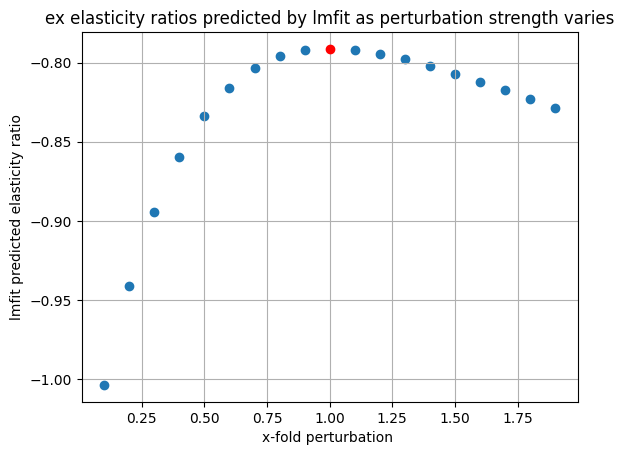

In [29]:
plt.figure()
plt.scatter(pt_levels, ratios)
plt.grid()
plt.title('ex elasticity ratios predicted by lmfit as perturbation strength varies')
plt.xlabel('x-fold perturbation ')
plt.ylabel('lmfit predicted elasticity ratio')
plt.plot(1,first_ratio,'ro') 


In [93]:
r.getScaledFluxControlCoefficientMatrix()

            J1,       J2
J1 [[ 0.558306, 0.441694],
J2  [ 0.558306, 0.441694]]